## Part 2)

- For the same person from step 1), use the Wikipedia API to access the whole content of that person's Wikipedia page.
- The goal of part 2) is to produce the capability to:
  1. For that Wikipedia page determine the sentiment of the entire page
  1. Print out the Wikipedia article
  1. Collect the Wikipedia pages from the 10 nearest neighbors in Step 1)
  1. Determine the nearness ranking of these 10 to your main subject based on their entire Wikipedia page
  1. Compare the nearest ranking from Step 1) with the Wikipedia page nearness ranking

In [3]:
%%capture

!pip install wikipedia

import wikipedia
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors 
from sklearn.decomposition import TruncatedSVD 

import nltk 
nltk.download('punkt') 
nltk.download('averaged_perceptron_tagger') 
nltk.download('wordnet') 
nltk.download('stopwords')

from textblob import TextBlob, Word, Blobber



BoW Ranking:
1. Stephen Hawking
2. Marie Curie
3. Charles Darwin
4. Galileo Galilei
5. Richard Feynman
6. Nikola Tesla
7. Isaac Newton

TF-IDF Ranking:
1. Marie Curie
2. Stephen Hawking
3. Charles Darwin
4. Galileo Galilei
5. Richard Feynman
6. Nikola Tesla
7. Isaac Newton


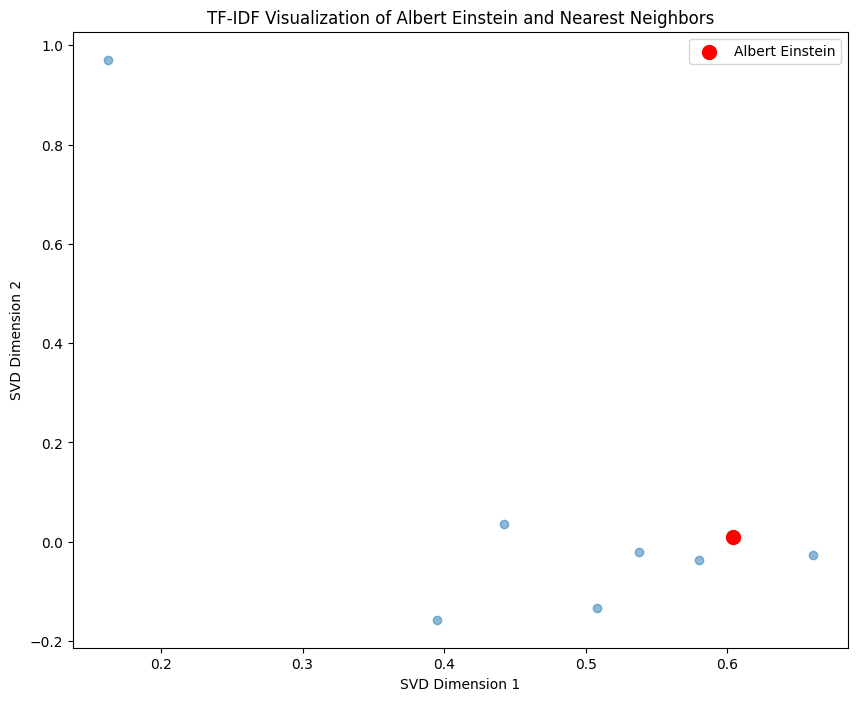


Sentiment of Albert Einstein's Wikipedia page:
Polarity: 0.12089698692683754
Subjectivity: 0.41579735217794905

Wikipedia article for Albert Einstein:
albert einstein (14 march 1879 – 18 april 1955) wa a german-born theoretical physicist who is widely held a one of the most influential scientists. best known for developing the theory of relativity, einstein also made important contribution to quantum mechanics. hi mass–energy equivalence formula e = mc2, which arise from special relativity, ha been called "the world' most famou equation". he received the 1921 nobel prize in physics. born in the german empire, einstein moved to switzerland in 1...

Comparison of rankings:
Marie Curie: Original rank 1, Wikipedia rank 1
Isaac Newton: Original rank 2, Wikipedia rank 7
Galileo Galilei: Original rank 3, Wikipedia rank 4
Stephen Hawking: Original rank 4, Wikipedia rank 2
Richard Feynman: Original rank 5, Wikipedia rank 5
Nikola Tesla: Original rank 6, Wikipedia rank 6
Charles Darwin: Origina

In [6]:
def get_wikipedia_content(person_name):
    try:
        page = wikipedia.page(person_name)
        return page.content
    except wikipedia.exceptions.PageError:
        return None

def clean_text(text):
    text = text.lower()
    words = text.split()
    singularized_words = [Word(word).singularize() for word in words]
    return ' '.join(singularized_words)

def analyze_wikipedia_content(person_name, nearest_neighbors):
    # Fetch Wikipedia content for the main person
    main_content = get_wikipedia_content(person_name)
    
    if main_content is None:
        print(f"No Wikipedia page found for {person_name}")
        return None, None, None, None
    
    # Clean the main content
    main_content = clean_text(main_content)
    
    # Collect and clean Wikipedia pages from the nearest neighbors
    neighbor_contents = []
    for neighbor in nearest_neighbors:
        content = get_wikipedia_content(neighbor)
        if content is not None:
            neighbor_contents.append(clean_text(content))
    
    if len(neighbor_contents) < 2:
        print("Not enough data to perform analysis. Skipping ranking.")
        return None, None, None, None
    
    # Create Bag of Words and TF-IDF representations
    bow_vectorizer = CountVectorizer(stop_words='english')
    bow_matrix = bow_vectorizer.fit_transform([main_content] + neighbor_contents)

    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform([main_content] + neighbor_contents)
    
    # Calculate cosine similarity
    bow_similarity = cosine_similarity(bow_matrix[0].reshape(1, -1), bow_matrix[1:])
    tfidf_similarity = cosine_similarity(tfidf_matrix[0].reshape(1, -1), tfidf_matrix[1:])
    
    # Calculate rankings
    bow_ranking = np.argsort(bow_similarity[0])[::-1]
    tfidf_ranking = np.argsort(tfidf_similarity[0])[::-1]
    
    # Create ranked lists of neighbors
    bow_wikipedia_ranking = [nearest_neighbors[i] for i in bow_ranking]
    tfidf_wikipedia_ranking = [nearest_neighbors[i] for i in tfidf_ranking]
    
    return main_content, bow_wikipedia_ranking, tfidf_wikipedia_ranking, tfidf_matrix

# Test the function
person_name = "Albert Einstein"  # Use a well-known person as an example
nearest_neighbors = ["Marie Curie", "Isaac Newton", "Galileo Galilei", "Stephen Hawking", "Richard Feynman", "Nikola Tesla", "Charles Darwin", "Aristotle", "Archimedes", "Leonardo da Vinci"]

main_content, bow_wikipedia_ranking, tfidf_wikipedia_ranking, tfidf_matrix = analyze_wikipedia_content(person_name, nearest_neighbors)

if main_content is not None:
    print(f"\nBoW Ranking:")
    for i, neighbor in enumerate(bow_wikipedia_ranking):
        print(f"{i+1}. {neighbor}")

    print("\nTF-IDF Ranking:")
    for i, neighbor in enumerate(tfidf_wikipedia_ranking):
        print(f"{i+1}. {neighbor}")

    # Visualization
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_svd = svd.fit_transform(tfidf_matrix)

    plt.figure(figsize=(10, 8))
    plt.scatter(X_svd[1:, 0], X_svd[1:, 1], alpha=0.5)
    plt.scatter(X_svd[0, 0], X_svd[0, 1], color='red', s=100, label=person_name)
    plt.title(f"TF-IDF Visualization of {person_name} and Nearest Neighbors")
    plt.xlabel("SVD Dimension 1")
    plt.ylabel("SVD Dimension 2")
    plt.legend()
    plt.show()

    # Calculate sentiment of the entire page
    main_sentiment = TextBlob(main_content).sentiment
    print(f"\nSentiment of {person_name}'s Wikipedia page:")
    print(f"Polarity: {main_sentiment.polarity}")
    print(f"Subjectivity: {main_sentiment.subjectivity}")

    # Print out the Wikipedia article
    print(f"\nWikipedia article for {person_name}:")
    print(main_content[:500] + "...")

    # Compare rankings
    original_ranking = nearest_neighbors
    print("\nComparison of rankings:")
    for i in range(len(original_ranking)):
        if original_ranking[i] in tfidf_wikipedia_ranking:
            print(f"{original_ranking[i]}: Original rank {i+1}, Wikipedia rank {tfidf_wikipedia_ranking.index(original_ranking[i])+1}")
        else:
            print(f"{original_ranking[i]}: Original rank {i+1}, Not found in Wikipedia ranking")
else:
    print(f"No Wikipedia page found for {person_name}. Unable to perform analysis.")
